Model Definition

In [1]:
# import necessary packages

import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from functools import reduce
from functools import partial

os.chdir("..")

from timeit import default_timer
import scipy.io
import sys
from itertools import chain
import skfmm
import time

from models.TrainPlanningOperator4D import PlanningOperator4D, smooth_chi
from models.utilities import *
from scipy.io import loadmat
from planner import getPNOValueFunction, perform_gradient_descent, generaterandompos


Loading the Trained Model and Maps

In [2]:
maps = loadmat('dataset/occupancyGridsSphere.mat') 
maps = 1 - maps['occupancyGrids']
testmaps = maps[10:,:,:,:,:] #Unseen Maps
goalpos = generaterandompos(maps)
startpos = generaterandompos(maps)

modes = 3
width = 7
nlayers = 1

model = PlanningOperator4D(modes, modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("dataset/manipulator/planningoperator_manipulator17_m3_w8_l1_b10_lr3e-3_10g_20nov/n400_lr1.000000e-02_gamma6.000000e-01_wd3.000000e-06_seed5/model4d.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

PlanningOperator4D(
  (fc0): Linear(in_features=4, out_features=7, bias=True)
  (conv0): SpectralConv4d()
  (w0): Conv4d(
    (conv3d_layers): ModuleList(
      (0): Conv3d(7, 7, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
  )
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=7, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Compute Value Function and Generate Trajectories

Success: True Path Length: 17.192023676495612


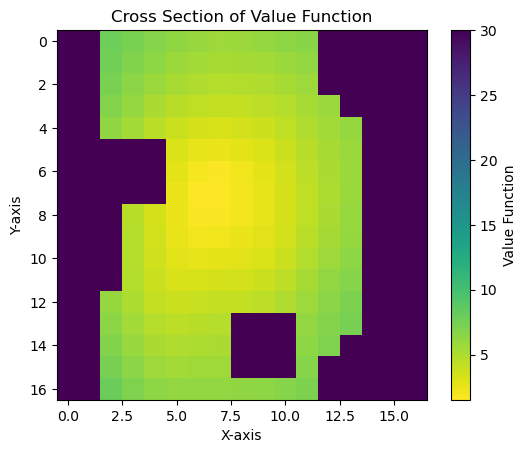

In [3]:
test_idx = 0

teststart = startpos[test_idx,:].squeeze()
testgoal = goalpos[test_idx,:].squeeze()
testmap = testmaps[test_idx,:,:,:,:].squeeze()

valuefunction =  getPNOValueFunction(testmap, testgoal, model)
success, path_length, path = perform_gradient_descent(valuefunction, teststart, testgoal)
print("Success:",success, "Path Length:", path_length)

# Plot Cross Section of the Value Function generated
# Colour Grading
cmap = plt.cm.viridis
cmap_inverted = LinearSegmentedColormap.from_list("inverted_viridis", cmap(np.linspace(1, 0, 256)))


plt.imshow(valuefunction[:, :, 6, 13], cmap=cmap_inverted,vmax = 30)  # Use a colormap for better visualization
plt.colorbar(label="Value Function")  # Add colorbar as a legend
plt.title("Cross Section of Value Function")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


Visualize Results

In [5]:
import os
from urdfpy import URDF


robot = URDF.load('ur5robot.urdf')



ValueError: ur5robot.urdf is not a file

Old stuff

In [ ]:
# Compare against classical Planners
nosuceesscount = 0
notime = 0
nopath = 0

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device)[0,:,:,:,:,0].reshape(1,Sx,Sy,Sz,Sa,1), chi.to(device)[0,:,:,:,:,0].reshape(1,Sx,Sy,Sz,Sa,1), ground_truth.to(device)[0,:,:,:,:,0].reshape(1,Sx,Sy,Sz,Sa,1), gg.to(device)[0,:,0].reshape(1,4,1)
        goal_point = np.array([13,8,8,10])
        gg = torch.tensor(goal_point, device=device).reshape(1, 4, 1)
        start_point = np.array([2,9,11,4])
        
        # Neural Operator Planning
        # t1 = tic()
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output)
        value_function = predicted_output[0, :, :, :, :, 0].cpu().detach().numpy()
        success_po, pathlength_po, path  = perform_gradient_descent(value_function,start_point,goal_point,learning_rate=1)
        # dt = toc(t1)

        if(success_po):
            nosuceesscount+=1
            nopath+=pathlength_po

        value_function_fmm = ground_truth
        value_function_fmm = torch.where(mask == 0, torch.tensor(float('inf')), value_function_fmm)
        value_function_fmm = value_function_fmm[0, :, :, :, :, 0].cpu().detach().numpy()
        success_fmm, pathlength_fmm, _  = perform_gradient_descent(value_function_fmm,start_point,goal_point,learning_rate=1)
        # dt = toc(t1)

        if(success_fmm):
            fmmsuceesscount+=1
            fmmpath+=pathlength_fmm     

        if batch_id==100:     
         break      


print("Planning Operator\nPath Lenght",pathlength_po,
      "\nSuccess:",success_po)



Planning Operator
Path Lenght 19.14553541208296 
Success: True

FMM
Path Lenght 0 
Success: False


In [ ]:
map_2 = mask[0,:,:,:,:,0].cpu().detach().numpy()
ground_truth_2 = scikitFMM(map_2,goal_point)
ground_truth_2[ground_truth_2>1e2] = 0
value_function[value_function>1e2] = 0
value_function2 = value_function

map_1 = mask[0,:,:,:,:,0].cpu().detach().numpy()
ground_truth_1 = scikitFMM(map_1,goal_point)
ground_truth_1[ground_truth_1>1e2] = 0
value_function[value_function>1e2] = 0
value_function1 = value_function


In [ ]:
data = {
    "value_function1": value_function1,
    "ground_truth_1": ground_truth_1,
    "value_function2": value_function2,
    "ground_truth_2": ground_truth_2,
}

# Saving the dictionary as a single .npy file
np.save("combined_data.npy", data)

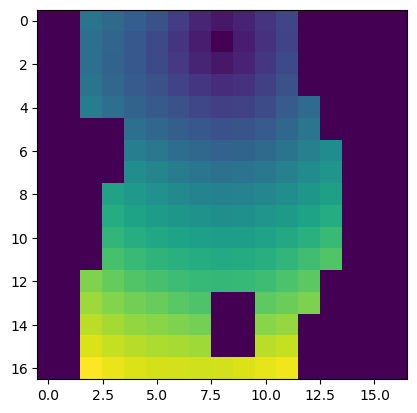

In [ ]:
plt.imshow(value_function[:,:,8,8])

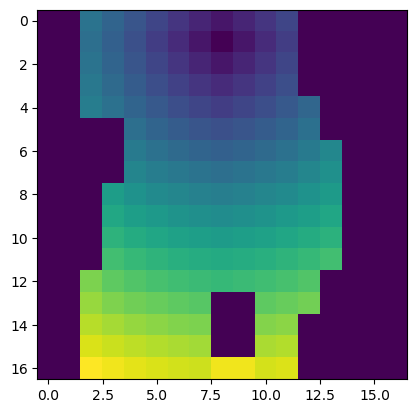

In [ ]:
plt.imshow(ground_truth_1[:,:,8,8])

In [ ]:
ground_truth_1[:,:,8,8]

array([[1.00000000e+20, 1.00000000e+20, 6.23567001e+00, 5.27108336e+00,
        4.32098970e+00, 3.39582044e+00, 2.51447807e+00, 1.70710678e+00,
        1.00000000e+00, 1.70710678e+00, 2.51447807e+00, 3.39582044e+00,
        1.00000000e+20, 1.00000000e+20, 1.00000000e+20, 1.00000000e+20,
        1.00000000e+20],
       [1.00000000e+20, 1.00000000e+20, 6.00000000e+00, 5.00000000e+00,
        4.00000000e+00, 3.00000000e+00, 2.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00,
        1.00000000e+20, 1.00000000e+20, 1.00000000e+20, 1.00000000e+20,
        1.00000000e+20],
       [1.00000000e+20, 1.00000000e+20, 6.23567001e+00, 5.27108336e+00,
        4.32098970e+00, 3.39582044e+00, 2.51447807e+00, 1.70710678e+00,
        1.00000000e+00, 1.70710678e+00, 2.51447807e+00, 3.39582044e+00,
        1.00000000e+20, 1.00000000e+20, 1.00000000e+20, 1.00000000e+20,
        1.00000000e+20],
       [1.00000000e+20, 1.00000000e+20, 6.55385617e+00, 5.636

In [ ]:
value_function[16,2,0,14]

inf

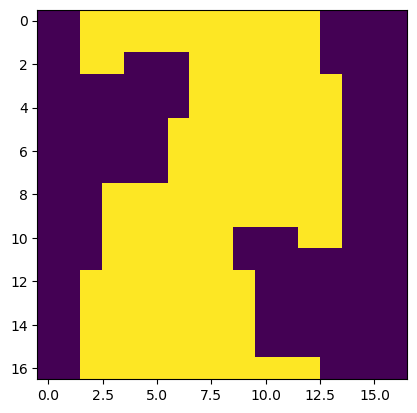

In [ ]:
plt.imshow(maps[41,:,:,5,4])

In [4]:
path

[array([ 1., 11.,  7.,  6.]),
 array([ 2., 12.,  8.,  6.]),
 array([ 3., 12.,  8.,  7.]),
 array([ 3., 13.,  7.,  7.]),
 array([ 4., 14.,  6.,  7.]),
 array([ 5., 15.,  5.,  7.]),
 array([ 6., 16.,  4.,  7.]),
 array([ 7., 16.,  4.,  8.]),
 array([ 8., 16.,  3.,  8.]),
 array([ 7., 16.,  3.,  8.]),
 array([ 8., 16.,  4.,  8.]),
 array([ 8., 16.,  3.,  7.]),
 array([ 9., 16.,  3.,  8.]),
 array([ 8., 16.,  3.,  9.]),
 array([ 7., 16.,  3.,  9.]),
 array([ 6., 16.,  3.,  8.]),
 array([ 7., 16.,  3.,  7.]),
 array([ 8., 16.,  4.,  7.]),
 array([ 9., 16.,  4.,  8.]),
 array([ 8., 16.,  4.,  9.]),
 array([ 7., 16.,  4.,  9.]),
 array([ 6., 16.,  4.,  8.]),
 array([ 7., 16.,  4.,  7.]),
 array([ 6., 16.,  3.,  7.]),
 array([ 5., 16.,  3.,  8.]),
 array([ 6., 16.,  3.,  9.]),
 array([ 6., 16.,  4.,  9.]),
 array([ 5., 16.,  4.,  8.]),
 array([ 5., 16.,  3.,  9.]),
 array([ 5., 16.,  4.,  9.]),
 array([ 6., 16.,  4., 10.]),
 array([ 7., 16.,  3., 10.]),
 array([ 7., 16.,  2.,  9.]),
 array([ 8